# Selectively downloading only string quartet scores

The MuseScore website contained a large repository of user submitted sheetmusic. These music files can be converted into machine readable arrays. We must first download all available string quartet music files to form our training data. We will filter the the files by its metadata, specifically the file `partsNames` should only contain `Violin 1`, `Violin II`, `Viola`, and `Violoncello`.

In [31]:
import jsonlines

quartets = []
with jsonlines.open('./score.jsonl') as f:
    for num, line in enumerate(f.iter()):
        print(num, end='\r')
        if line['partsNames'] == ['Violin I', 'Violin II', 'Viola', 'Violoncello']:
            quartets.append(line)

We can see here that only ~6,000 of the files out of ~1,500,000 files are string quartets.

In [36]:
import pandas as pd


pd.DataFrame(quartets).to_csv('./quartets_meta.csv')

In [49]:
df_quartets_meta = pd.read_csv('./quartets_meta.csv')

df_quartets_meta['id']

0       6023294
1       6022647
2       6023028
3       6022249
4       6023216
         ...   
6408    5490785
6409    5253056
6410    5243899
6411    5758703
6412    5760970
Name: id, Length: 6413, dtype: int64

## Utilization the InterPlanetary File System repository

Fortunately for us much of the files on MuseScore have already been scraped by others and placed onto the IPFS distributed file repository. This greatly facilatated download the files as we would not have to use MuseScore's API.

In [45]:
df_url = pd.read_csv('./mscz-files.csv').drop('path', axis=1)

df_url

,id,ref
0,6218789,/ipfs/Qme8gx1EYUjmkaMvtZezpoMWN62mqJCmTbtLZJGz...
1,6219435,/ipfs/QmXhGQR2WSg6tjip3UV4caAx74NZvdyzS1QEfQVJ...
2,6219793,/ipfs/Qmb9bXxmRXoC8nXm9iLzcw4JBDSat2BFtPX7tVHW...
3,6219814,/ipfs/QmfJ6JnRYT45AtF8cnQea3ncUTKH2HnvJDNVs2yw...
4,6218610,/ipfs/QmZMSCpqfcdagQbyAPx3tuApWLTFpQY6MJfSPeET...
...,...,...
1539136,6078001,/ipfs/QmdqGJPxS9JUUcLrqyXHDbJBbxCZPaTEoRgeiXeT...
1539137,6092760,/ipfs/Qmd9ZGrj6Dnk79PXEDhHFaCLv3NMvwJWKffXrxFy...
1539138,6138284,/ipfs/QmX8qcLFZyoxWHxGoErpi1MDHJkiwRUHZVVBEAVL...
1539139,6138470,/ipfs/QmXgyC4AGx4JBrtUQ5vYhbN1bBJouPgtmqydQobt...


In [52]:
df_quartets = pd.merge(df_quartets_meta, df_url, left_on='id', right_on='id')


df_quartets['ref']

0       /ipfs/QmZVHj7zENw1KnTwJBHUSEwD83rNEGbXPAcM9UXm...
1       /ipfs/QmbZyhprd7D9Tc5DkqUp5D7XhWQuwBy83xgD23xs...
2       /ipfs/QmaFVSBqG6mfVJLLyLg8Rdt28xXZTsBLF2VR1nfp...
3       /ipfs/QmPFfQDPmHQLbRxiPCGYEfiei2zRNpY7yQLw88oq...
4       /ipfs/Qmex89sLK5QSbAdbMunQAmpihWkvKHxCWYR27ndk...
                              ...                        
6409    /ipfs/QmWmUR5vEFrYAGeBux6W4cTwLbD71YM98zN8dmXi...
6410    /ipfs/QmWmWbHw3kLFLpvgEnNNULAjk6Q6EbUxXjWKm7Ea...
6411    /ipfs/QmbESa73JhUUYTP6znGMvqFkwH6a4jEy5CZgBapp...
6412    /ipfs/QmaQimtPP6Z8uSJUTjUaoYPBb6nyHjGwhQ1vtZA4...
6413    /ipfs/QmVGWPExf9DJiFyuj2D8rWuVSsGpjVyLo31A2jFf...
Name: ref, Length: 6414, dtype: object

In [54]:
test_ref = df_quartets['ref'].iloc[134]
url_head = 'https://ipfs.io'

url = url_head + test_ref
url

'https://ipfs.io/ipfs/QmSm3qFnyiX2xqUcVpaq1C5c4ya5zLQByzv8bkwKT4z9ar'

## Downloading the zipped music files

By identifying the ID of the string quartet music files, we can filter out the download URL on IPFS for only those files. After that, it is trivial to download them via `requests`. The files are zipped along with some meta-data files. We will unzip these and only retain the `.mscx` music files.

In [62]:
test_id = df_quartets.iloc[134]['id']

In [77]:
import requests


response = requests.get(url)
with open(f'./{test_id}.zip', 'wb') as f:
    f.write(response.content)

In [84]:
from zipfile import ZipFile


with ZipFile(f'./{test_id}.zip', 'r') as f:
    [f.extract(file, './') for file in f.namelist() if file.endswith('mscx')]

In [89]:
with open(f'./temp.mscx', 'r') as f:
    test_file_read = f.read()

The `.mscx` are essentially a variant of xml files.

In [90]:
print(test_file_read)

<?xml version="1.0" encoding="UTF-8"?>
<museScore version="2.06">
  <programVersion>2.0.0</programVersion>
  <programRevision>6e47f74</programRevision>
  <Score>
    <LayerTag id="0" tag="default"></LayerTag>
    <currentLayer>0</currentLayer>
    <Synthesizer>
      </Synthesizer>
    <Division>480</Division>
    <Style>
      <page-layout>
        <page-height>1683.36</page-height>
        <page-width>1190.88</page-width>
        <page-margins type="even">
          <left-margin>56.6929</left-margin>
          <right-margin>56.6929</right-margin>
          <top-margin>56.6929</top-margin>
          <bottom-margin>113.386</bottom-margin>
          </page-margins>
        <page-margins type="odd">
          <left-margin>56.6929</left-margin>
          <right-margin>56.6929</right-margin>
          <top-margin>56.6929</top-margin>
          <bottom-margin>113.386</bottom-margin>
          </page-margins>
        </page-layout>
      <Spatium>1.76389</Spatium>
      </Style>
    <showInv

## Converting `.mscx` files to `xml`

While MuseScore is opensource, the music files they produce is a specific variant of xml that is particular to them. We must convert them to xml (specifically to `musicXML`) as a common framework for other packages to be able to read them. To do so, we will utilize the `music21` Python package.

In [94]:
import subprocess


subprocess.run(['MuseScore3.exe', 'temp.mscx', '-o', 'temp.mxl'])

CompletedProcess(args=['MuseScore3.exe', 'temp.mscx', '-o', 'temp.mxl'], returncode=0)

In [102]:
import music21


test_parsed = music21.converter.parse('./temp.mxl')

Once converted to `musicXML`, `music21` can parse the music file, teasing out notes and parts with ease.

In [105]:
test_parsed.show('text')

{0.0} <music21.text.TextBox 'Kanon 3 wę...'>
{0.0} <music21.metadata.Metadata object at 0x217a89cbc40>
{0.0} <music21.stream.PartStaff P1-Staff1>
    {0.0} <music21.instrument.Instrument 'P1: Piano: Piano'>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.KeySignature of no sharps or flats>
        {0.0} <music21.meter.TimeSignature 6/8>
        {0.0} <music21.note.Rest rest>
    {3.0} <music21.stream.Measure 2 offset=3.0>
        {0.0} <music21.note.Note D>
        {0.5} <music21.note.Note G>
        {1.5} <music21.note.Note A>
        {2.0} <music21.note.Note B->
        {2.5} <music21.note.Note C>
    {6.0} <music21.stream.Measure 3 offset=6.0>
        {0.0} <music21.note.Note B->
        {0.5} <music21.note.Note A>
        {1.0} <music21.note.Note F#>
        {1.5} <music21.note.Note G>
    {9.0} <music21.stream.Measure 4 offset=9.0>
        {0.0} <music21.note.Note G>
    

In [ ]:
music21.environment.UserSettings()['musicxmlPath'] = r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe'

In [6]:
music21.environment.set('musicxmlPath', '/usr/bin/musescore3')

In [117]:
music21.environment.set('musescoreDirectPNGPath', r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe')

In [7]:
music21.environment.set('musescoreDirectPNGPath', '/usr/bin/musescore3')

In [ ]:
music21.environment.set('musicxmlPath', r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe')

We can check the music file as sheet music by rendering them with `music21` with the help of MuseScore.

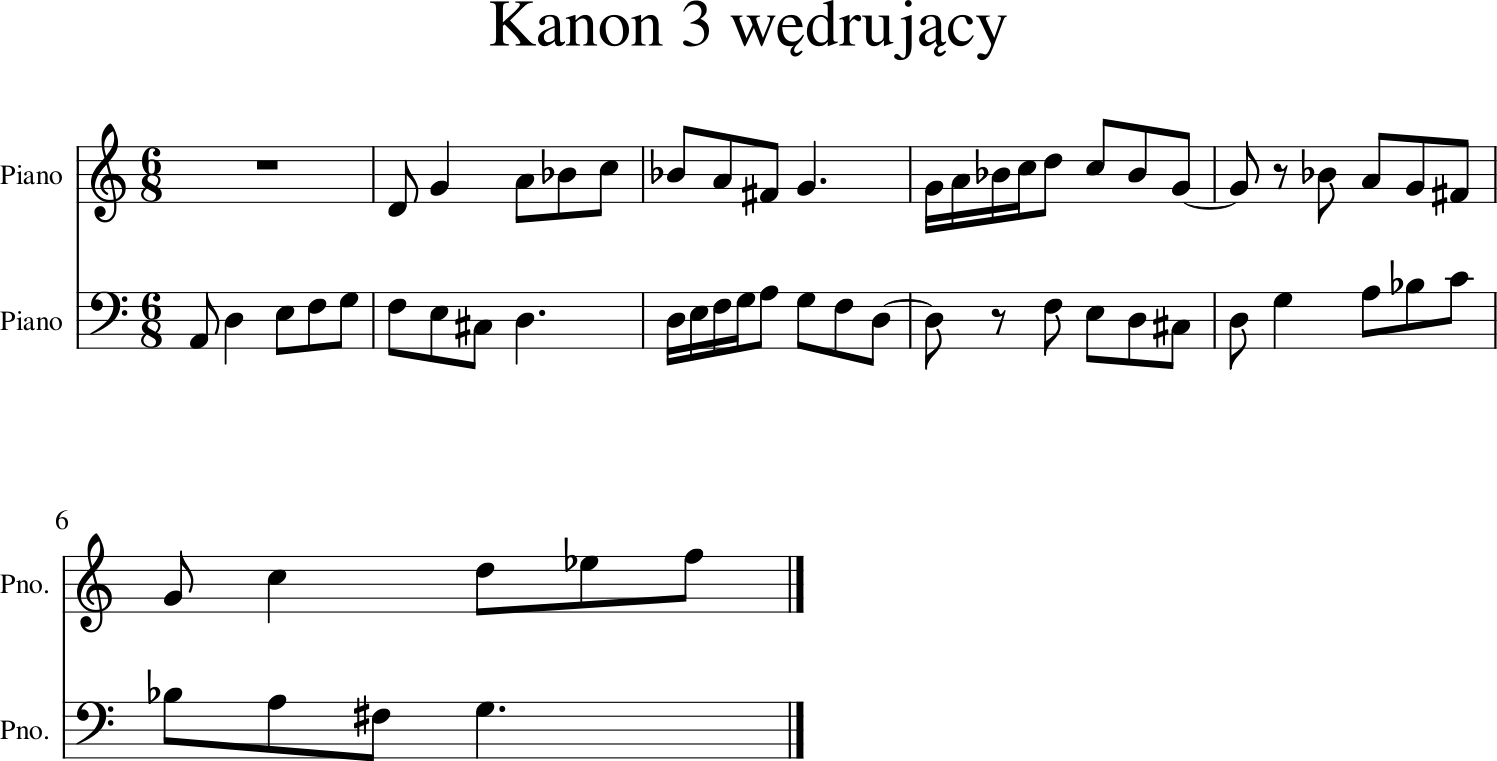

In [118]:
test_parsed.show()

## Batch converting

Converting large amount of `.mscx` files to xml will take time.

In [143]:
for num, (id, ref) in enumerate(zip(df_quartets['id'], df_quartets['ref'])):
    url = url_head + ref
    response = requests.get(url)
    print(f'Writing {id}.zip...', end='\t')
    with open(f'./scores/{id}.zip', 'wb') as f:
        f.write(response.content)
        print(f'done.    File count = {num + 1}')
    

Writing 6023294.zip...	done.    File count = 1
Writing 6022647.zip...	done.    File count = 2
Writing 6023028.zip...	done.    File count = 3
Writing 6022249.zip...	done.    File count = 4
Writing 6023216.zip...	done.    File count = 5
Writing 6023500.zip...	done.    File count = 6
Writing 6076434.zip...	done.    File count = 7
Writing 6082353.zip...	done.    File count = 8
Writing 6110320.zip...	done.    File count = 9
Writing 6288846.zip...	done.    File count = 10
Writing 6288846.zip...	done.    File count = 11
Writing 6288846.zip...	done.    File count = 12
Writing 6288846.zip...	done.    File count = 13
Writing 6024318.zip...	done.    File count = 14
Writing 6030030.zip...	done.    File count = 15
Writing 6028817.zip...	done.    File count = 16
Writing 6034656.zip...	done.    File count = 17
Writing 6034656.zip...	done.    File count = 18
Writing 6046296.zip...	done.    File count = 19
Writing 6038177.zip...	done.    File count = 20
Writing 6040975.zip...	done.    File count = 21
W

ConnectionError: ('Connection aborted.', ConnectionResetError(10054, 'An existing connection was forcibly closed by the remote host', None, 10054, None))

In [144]:
for num, (id, ref) in enumerate(zip(df_quartets['id'].iloc[4935:], df_quartets['ref'].iloc[:4935])):
    url = url_head + ref
    response = requests.get(url)
    print(f'Writing {id}.zip...', end='\t')
    with open(f'./scores/{id}.zip', 'wb') as f:
        f.write(response.content)
        print(f'done.    File count = {num + 1}')

Writing 4797520.zip...	done.    File count = 1
Writing 5087808.zip...	done.    File count = 2
Writing 5857966.zip...	done.    File count = 3
Writing 2295926.zip...	done.    File count = 4
Writing 5374983.zip...	done.    File count = 5
Writing 4926538.zip...	done.    File count = 6
Writing 1344666.zip...	done.    File count = 7
Writing 5663773.zip...	done.    File count = 8
Writing 5277754.zip...	done.    File count = 9
Writing 5104221.zip...	done.    File count = 10
Writing 6003505.zip...	done.    File count = 11
Writing 5916148.zip...	done.    File count = 12
Writing 5995977.zip...	done.    File count = 13
Writing 2255381.zip...	done.    File count = 14
Writing 4254366.zip...	done.    File count = 15
Writing 4545971.zip...	done.    File count = 16
Writing 5824751.zip...	done.    File count = 17
Writing 5250031.zip...	done.    File count = 18
Writing 5645190.zip...	done.    File count = 19
Writing 5210041.zip...	done.    File count = 20
Writing 4299706.zip...	done.    File count = 21
W

In [151]:
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir('./scores/') if isfile(join('./scores/', f))]

In [153]:
onlyfiles[:10]

['102127.zip',
 '1034861.zip',
 '1037631.zip',
 '1039806.zip',
 '1040801.zip',
 '1041266.zip',
 '1046476.zip',
 '1046491.zip',
 '1049471.zip',
 '1050051.zip']

In [162]:
from zipfile import BadZipFile


bad_zips = []
good_zips = []

for file in onlyfiles:
    try:
        with ZipFile(f'./scores/{file}', 'r') as f:
            for file in f.namelist():
                if file.endswith('mscx'):
                    if file in good_zips:
    except BadZipFile:
        print(f'{file} is a bad zip file. Skipping')
        bad_zips.append(file)

In [163]:
onlyzips = [f for f in listdir('./unzipped/') if isfile(join('./unzipped/', f))]

onlyzips[:100]

['!!!!!StringQuartetNo.3(3rd_Mov.).mscx',
 '!!!!!StringQuartetNo.3(3rd_Mov.)_1.mscx',
 '!hAyDn_CoMpOsItIon_TeChNiQuEs!.mscx',
 '(auf_dem_Weg_nach_Stuttgart).mscx',
 '(auf_dem_Weg_nach_Stuttgart)V2.mscx',
 '......mscx',
 '....._1.mscx',
 '....mscx',
 '.Leaning on the Everlasting Arms.mscx',
 '.Revised String Quartet in C# minor.mscx',
 '.Revised String Quartet in C# minor_1.mscx',
 '0)19str_2020June6.mscx',
 '0)19str_2020June6_1.mscx',
 '009 - MARCHAI,_SOLDADOS_DE_CRISTO.mscx',
 '09 2 Quartet per cordes, adagio (pels m├║sics).mscx',
 '0Here_comes_the_sun.mscx',
 '0Here_comes_the_sun_1.mscx',
 '0w0.mscx',
 '0w0_1.mscx',
 '1,_2,_3,_4.mscx',
 '1. This is Halloween.mscx',
 '1. This is Halloween_1.mscx',
 '1.2.mscx',
 '1.2_1.mscx',
 '1.mscx',
 '1._Overture Vln I&II.mscx',
 '100 Seconds for Strings.mscx',
 '12-Tone Composition Project MUTH 2500.mscx',
 '12-Tone Composition Project MUTH 2500_1.mscx',
 '12-Tone Extreme.mscx',
 '12-Tone Extreme_1.mscx',
 '12-Tone Final Draft.mscx',
 '12-Tone Fin

In [164]:
len(onlyzips)

6387

In [ ]:
# subprocess.run(['MuseScore3.exe', 'temp.mscx', '-o', 'temp.mxl'])


for num, file in enumerate(onlyzips):
    print(f'Converting {file} (file number {num})...\t\t\t', end='\t')
    subprocess.run(['MuseScore3.exe', f'./unzipped/{file}', '-o', f'./mxl/{file}.mxl'])
    print('...Done.', end='\r')

Converting the nipin nelly.mscx (file number 5888)...				 5887)...				)...							)...							 2775)...				...				..Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done....Done..

## Converting to input to Midi

The Coconet model essentially accept NumPy array representation of music as input. The easiest way to do so is to convert the music file to MIDI. `music21` will allow us to do that.

In [17]:
midi_parsed = music21.converter.parse('./test.midi')

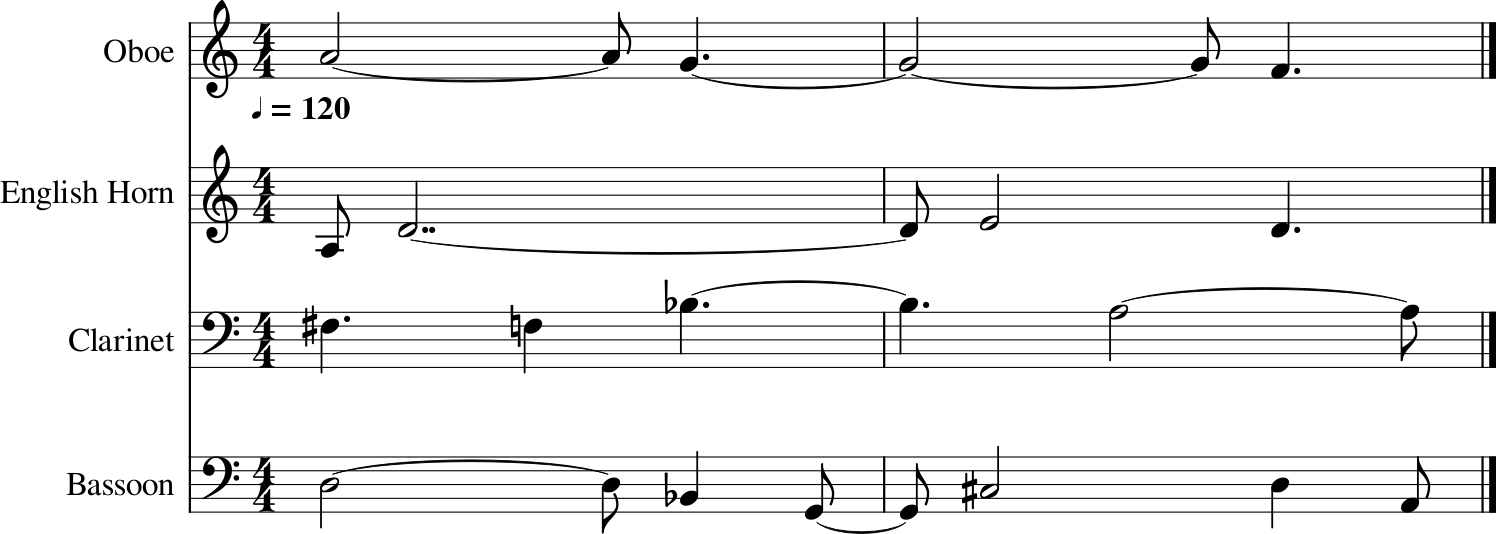

In [18]:
midi_parsed.show()